Rb Calculations (formerly known as Matrix Elements)

Preston Huft, May 2019.

https://docs.sympy.org/latest/modules/physics/wigner.html

sympy.physics.wigner.clebsch_gordan(j_1, j_2, j_3, m_1, m_2, m_3)[source], ⟨j1m1j2m2|j3m3⟩.
sympy.physics.wigner.wigner_3j(j_1, j_2, j_3, m_1, m_2, m_3)[source]
sympy.physics.wigner.wigner_6j(j_1, j_2, j_3, j_4, j_5, j_6, prec=None)[source]

In [223]:
#%matplotlib notebook
from matplotlib import pyplot as plt
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from sympy import symbols,N
from sympy import MatrixSymbol,MatAdd,MatMul,Identity as eye,Matrix,zeros
from sympy.utilities.iterables import flatten
import numpy as np
from numpy import transpose
from numpy.linalg import eig
import math as m
from math import sqrt,pi

In [264]:
## physical constants
ee = 1.60217662e-19 # [C]
a0 = 5.22e-11 # [m]
hbar = 1.0545718e-34 # [J s]
c = 299792458 # [m/s]
e0 = 8.85418782e-12 # [m^-3 kg^-1 s^4 A^2]
u0 = 1.25663706e-6 # [m kg s^-2 A^-2]
me = 9.10938356e-31 # [kg]
uB = 9.274e-24 # [J/T]

## other constants
I = 3/2 # nuclear spin

## reduced matrix elements from Steck
D2_MatElem = 3.584e-29 # <J=1/2||er||J'=3/2> [C*m]
D1_MatElem = 2.537e-29 # <J=1/2||er||J'=1/2> [C*m]

def hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,RME=None):
    """ Returns the matrix element <F,mF,J|T_q|F',mF',J'>. 
    
        RME is the reduced matrix element (just a number), which can be calculated
        externally and passed in to be a multiplier. If RME=None, the 
        matrix element is in units of [RME].
        
        I is the nuclear spin of the atom.
    """

    rme = 1
    if RME!=None:
        rme = RME

    ## From Mark's notes, eqs. A-50,51
    mat_elem = rme*pow(-1,F+JJ+1+I)*sqrt((2*F+1)*(2*JJ+1)) \
                *wigner_6j(J,I,F,FF,1,JJ) \
                *clebsch_gordan(1,F,FF,q,mF,mFF)
    
    return mat_elem

def eff_rabi(O,D):
    """ the effective rabi frequency, given a rabi freq O, and 
        detuning D from the transition frequency"""
    return sqrt(O**2+D**2)

def jmbasis(jlist):
    """ returns a numpy array of basis vectors {|J,mJ>} given a list of 
        J vals"""
    basis = np.empty(sum([2*j+1 for j in jlist]),list)
    i = 0
    for j in jlist:
        for m in range(-j,j+1):
            basis[i] = [j,m]
            i+=1 
    return basis

def cc(z):
    return np.conj(z)

def radToTHz(w):
    return w/(2*pi*1e12)

def radToGHz(w):
    return w/(2*pi*1e9)

def radToMhz(w):
    return w/(2*pi*1e6)

def radTokHz(w):
    return w/(2*pi*1e3)

def JToeV(u):
    global ee
    return u/ee

def eVToJ(u):
    global ee
    return u*ee

def GHzToeV(nu):
    global hbar
    return JToeV(2*pi*hbar*nu*1e9)

def eVToGHz(u):
    global hbar
    return eVToJ(u)/(2*pi*hbar*1e9)


# def alpha(w_ab,w,RME,I):
#     """ the polarizability of a two-level atom in an AC electric field
#     """
#     return 

In [179]:
###################################################################
# calculate 2 photon Rabi frequency for the ground state hyperfine 
# Raman transition
###################################################################

P = 3.5e-6 # [W] light power at experiment cell
a = 6e-6 # [m]
b = 8e-6 # [m], in y direction
A = a*b*pi # area at beam waist 
E0 = sqrt(4*P/(c*e0*A)) # the electric field amplitude
d = 2*pi*4.5e10 # [Hz] Single photon detuning

#       hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,RME=None):
O1 = E0*hf_matrix_elem(2,0,1/2,1,2,1,3/2,I,D2_MatElem)/hbar
O2 = E0*hf_matrix_elem(1,0,1/2,1,2,1,3/2,I,D2_MatElem)/hbar

# Ignoring a.c. stark shifts, etc:

# O1 /= 1e9 # [GHz]
# O2 /= 1e9 #
# print(N(O1),N(O2))

O = N(abs(O1*O2/(2*d))/1e3)/(2*pi) # [kHz]
print(f"Two-photon Rabi frequency = 2*pi*{O:.2f} kHz")

Two-photon Rabi frequency = 2*pi*284.24 kHz


In [180]:
## for the raman pulse notebook
o1 = hf_matrix_elem(2,0,1/2,1,2,1,3/2,I,D2_MatElem)
o2 = hf_matrix_elem(1,0,1/2,1,2,1,3/2,I,D2_MatElem)
print(N(o1),N(o2))

-1.79200000000000e-29 1.79200000000000e-29


In [181]:
###################################################################
# Differential AC Stark Shifts
###################################################################

def scalar_ls(w_ab,w,I,RME=None):
    """ the scalar AC Stark shift, or light shift, seen by a two 
        level atom in an oscillating electric field.
        w_ab is the freq difference between a,b
        w is the applied light frequency
        I is the intensity of the light 
        RME is the reduced matrix element <J||r||J'>. Careful! This
        does not include the electron charge.
    """
    
    if RME is None:
        RME = 1 # the light shift is now in units of the RME
    
    return -(ee**2)*w_ab*cc(RME)*RME*I/(2*hbar*(w_ab**2-w**2))

In [182]:
# The D2 line differential light shift of Rb87 in a far-off-resonance
# trap (FORT)

w0 = 2*pi*384.2304844685e12 # D2 line transition frequency
wFORT = 2*pi*c/(1064e-9)

waist = 2.5e-6 # gaussian waist of the FORT
P = .5 # [W] approx at center site (e.g. during PGC phase)
Int = P/(pi*waist**2)

In [183]:
radToTHz(wFORT)

281.7598289473684

<IPython.core.display.Javascript object>


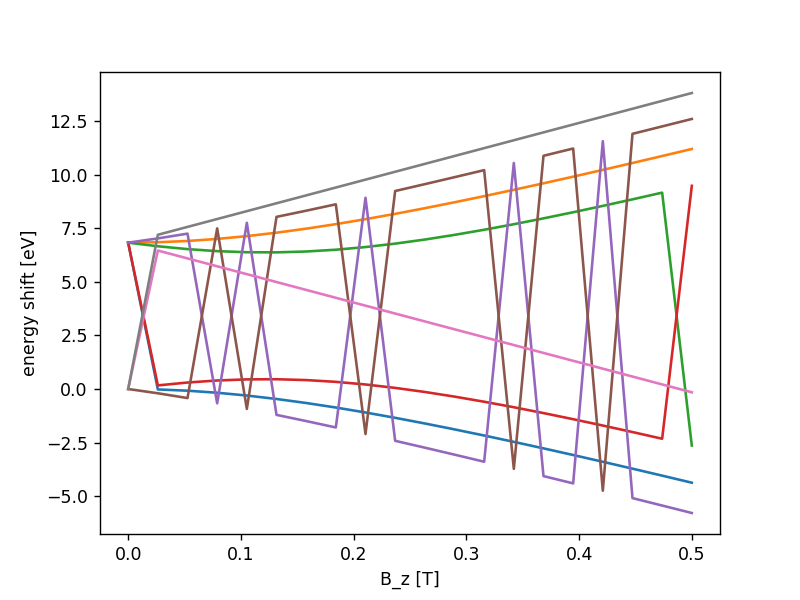

Text(0, 0.5, 'energy shift [eV]')

In [269]:
###################################################################
# HF Zeeman Shifts, small B field
###################################################################

def gF_fn(F,J,I,gJ,gI):
    
    return (gJ*(F*(F+1)+J*(J+1)-I*(I+1))
            +gI*(F*(F+1)-J*(J+1)+I*(I+1)))/(2*F*(F+1))

def gJ_fn(J,L,S,gL,gS):
    
    return (gL*(J*(J+1)+L*(L+1)-S*(S+1)) 
            +gS*(J*(J+1)-L*(L+1)+S*(S+1)))/(2*J*(J+1))

# def hf_zeeman(Bz,mF,gF):
#     """ Mark's notes, eq 4.21 gives <aJIFM|HZz|aJIFM> = uB*Bz*gF*M """
#     global uB
#     return uB*Bz*gF*mF

def hf_zeeman(states,Bz,gJ,gI):
    """See Mark's notes for the general hf Zeeman matrix elements"""
    global uB
    UB = uB*Bz # magnetic field potential energy
    
    I,J,F,mF,FF,mFF = states
    q = 0 # assume B = Bz for now
    
    elem = 0
    if mF == mFF:
        elem += UB*clebsch_gordan(F,1,FF,mF,q,mFF) \
                *sqrt(2*F+1)*(-1)**(1+J+I) \
                *(gJ*(-1)**F*sqrt(J*(J+1)*(2*J+1)) \
                *wigner_6j(J,I,F,FF,1,J) \
                +gI*(-1)**FF*sqrt(I*(I+1)*(2*I+1)) \
                *wigner_6j(I,J,F,FF,1,I))
    
    return elem

# Rb87 ground state 5s1/2:
L = 0; S = 1/2; J = 1/2;
Flist = [2,1] # F = I + J
nu_hf = 6.83468261090429 # [GHz]
E_hf = GHzToeV(nu_hf)

# Rb 87 Lande g factors
gS = 2.00023; gL = 1; gI = -0.000995
gJ = gJ_fn(J,L,S,gL,gS)

Bzlist = np.linspace(0,.50,20)

# ## initialize the figure
# fig = plt.figure()
# ax = fig.add_subplot(111)

## First order calculation for low B field
# for F in Flist:
#     gF = gF_fn(F,J,i,gj,gI)
#     zshifts = np.empty(len(Bzlist))
#     for mF in range(-F,F+1): # the hyperfine states
#         for i,Bz in enumerate(Bzlist): 
#             zshifts[i] = JToeV(hf_zeeman(Bz,mF,gF))
#         ax.plot(Bzlist,zshifts,label=f'|{F},{mF}>')
# ax.set_title("Rb87 |5s1/2> Hyperfine Zeeman Shifts (O(1))")

## General calculation for different field strength regimes

# Rb Hamiltonian for HF ground states in {|F,mF>} basis
H_a = E_hf*np.array([[1,0,0,0,0,0,0,0],
                    [0,1,0,0,0,0,0,0],
                    [0,0,1,0,0,0,0,0],
                    [0,0,0,1,0,0,0,0],
                    [0,0,0,0,1,0,0,0],
                    [0,0,0,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0]])

# Zeeman Hamiltonian for B = Bz
H_Zz = np.empty((8,8))
basis = jmbasis(Flist)
    
# Array to store the Zeeman shifts by hf state
zshifts = np.empty((len(Bzlist),len(basis)))

# Diagonalize the full Hamiltonian various B field strengths:
for k,Bz in enumerate(Bzlist):
    
    # Build the Zeeman Hamiltonian
    for i,state_i in enumerate(basis):
        F,mF = state_i
        for j,state_j in enumerate(basis):
            FF,mFF = state_j
            states = [I,J,F,mF,FF,mFF]
            try:
                H_Zz[i,j] = JToeV(hf_zeeman(states,Bz,gJ,gI))
            except:
                print("Failed: %s" % states)
    
    # Diagonalize the full Hamiltonian
    H = H_a + H_Zz 
    evals,evecs = eig(H)
    zshifts[k] = np.array([eVToGHz(u) for u in evals])

zshifts = transpose(zshifts)
    
## initialize the figure
fig = plt.figure()
ax = fig.add_subplot(111)

for shift in zshifts:
    ax.plot(Bzlist,shift)

ax.set_xlabel("B_z [T]")
ax.set_ylabel("energy shift [eV]")
# ax.legend(loc='upper right')
# plt.show()

In [68]:
# Test the Zeeman fn -- this agrees with Mark's result for i=3/2 alkalis
J=1/2; F=2; mF=1; FF=1; mFF=1;
states = [i,J,F,mF,FF,mFF]

gS = 2.00023; gL = 1; gI = -0.000995
gJ = gJ_fn(J,L,S,gL,gS)

(4/gS)*N(hf_zeeman(states,1,gJ,gI))

1.73291240376208